$\Large{\textbf{Minimum Variance Log-Optimal Investment}}$

Investment strategies are allowed to use information collected from the past of the market and determine,
at the beginning of a trading period, a portfolio, namely a way to distribute their current capital among
the available assets. The goal of the investor is to maximize his wealth on the long run without knowing the
underlying distribution generating the stock prices. Since accurate statistical modeling of stock market
behavior has been known as a notoriously difficult problem, we take an extreme point of view and work with
minimal assumptions on the distribution of the time series. In fact, the only assumption that we use in our
mathematical analysis is that the daily price relatives form a stationary and ergodic process. Under this
assumption the asymptotic rate of growth has a well-defined maximum which can be achieved in full knowledge
of the distribution of the entire process. The fundamental limits reveal that the so-called $\textit{log-optimal
    portfolio}$ is the best possible choice. 
$\textit{Reference: http://www.szit.bme.hu/~oti/portfolio/}$

$\textbf{Problem formulation}$

The log-optimal investment strategy is detailed in $[\textit{Boyd-Vandenberghe, Convex Optimization, Ex.4.60}]$, where
$n$ assets are held over $N$ time periods. The total wealth is re-invested at the beginning of each time period with a
fixed, constant allocation strategy $x\in\mathbb{R}^n$, with $x\succeq 0$ and $\mathbf{1}^\top x=1$. The return after 
each period $t$ is denoted with $\lambda(t)$. At the end of the $N$ periods our wealth has been multiplied by the factor $\Pi_{t=1}^N\lambda(t)$. The quantity
\begin{equation*}
 \frac{1}{N}\sum_{t=1}^N\mathrm{log}\lambda(t)
\end{equation*}
is called the $\textit{growth rate}$ of the investment over the $N$ periods.

We assume that the distribution of the returns is unknown and we only have certain realizations available. We assume that over each period there are $m$ possible scenarios with probabilities $\pi_j, \; j=1,\ldots,m$. In scenario $j$, the return for asset $i$ over one period is given by $p_{ij}$. Therefore, the return $\lambda(t)$ of our portfolio during period $t$ is a random variable, with $m$ possible values $p_1^\top x,\ldots p_m^\top x$, and distribution
\begin{equation*}
 \pi_j = \mathbb{P}[\lambda(t)=p_j^\top x], \; j=1,\ldots,m.
\end{equation*}

Using the law of large numbers, it can be shown that the long term growth rate is given by
\begin{equation*}
 R = \sum_{j=1}^m\pi_j\mathrm{log}(p_j^\top x).
\end{equation*}

One might also want to minimize the variance of the portfolio. Since the scenarios are the same in each period, the sample covariance matrix is given by
\begin{equation*}
 \Sigma = \frac{1}{m-1}(P-\bar{p}\mathbf{1}^\top)(P-\bar{p}\mathbf{1}^\top)^\top,
\end{equation*}
where $P=\begin{bmatrix}p_1&p_2& \ldots &p_m\end{bmatrix}$ and $\bar{p}$ is the sample mean of the returns.

Finally, the optimization problem reads
\begin{equation}
\begin{array}{ll}
  \mbox{minimize} & x^\top\Sigma x - \sum_{j=1}^m\pi_j\mathrm{log}(p_j^\top x)\\
  \mbox{subject to} & x\succeq 0, \; \mathbf{1}^\top x=1 \enspace.
\end{array}
\end{equation}

In [2]:
## Load packages and solvers

using Convex
using PyPlot
using ECOS
using Distributions

# Solver used
solver = ECOSSolver(verbose=false)

type Agent
    scenaria::Int16
    returns::Array{Float64, 2}
    probs::Array{Float64, 1}
    times::Array{Float64, 2}
end


    push!(DataStructures.Accumulator{#T<:Any, #V<:Number}, #T<:Any) at /Users/georgios/.julia/v0.4/DataStructures/src/accumulator.jl:54
is ambiguous with: 
    push!(Base.Associative, Base.Pair) at dict.jl:294.
To fix, define 
    push!(DataStructures.Accumulator{K<:Any, #V<:Number}, _<:Base.Pair)
before the new definition.


$\textbf{Problem data}$

The purpose is to solve the problem by assigning scenarios to several processors that execute their operations in parallel, in a continuous and asynchronous manner. 

Consider the following problem instance:
* $m$ = 200 scenarios
* $n$ = 16 stocks
* $N$ = 8 processors

The scenarios are distributed time invariantly to the processors in a random way. This means that each processor sticks to the scenarios that it has been assigned and the assignment does not change online. In addition, the constraints are radnomly assigned to some processor as well. 

In [3]:
## Minimum variance log-optimal investment strategy: Problem data

srand(1234)

global m, n # m: scenaria, n: stocks
m, n = 200, 16

global π # probability vector
π = rand(m,1)
π = π ./ sum(π)

global p # return per scenario
p = zeros(n,m)
[ p[:,j] = 1*rand(n) for j in 1 : m ]

global N # No of processors
N = 8

global Σ # covariance matrix
Σ = ((1/sqrt(m-1))*(p-mean(p,2)*ones(1,m))) * ((1/sqrt(m-1))*(p-mean(p,2)*ones(1,m)))'

global L # Lipschitz
L = eigmax(Σ)
# println(L)

global μ # strong convexity
μ = max(eigmin(Σ), 0)
# println(μ)

# Initialize agents
No_terms = rand(N);
No_terms = round(Int8, m * (No_terms / sum(No_terms)) )
if maximum(No_terms) > m
    val, idx = findmax(No_terms)
    No_terms[idx] = val - (max(No_terms)-m)
end
println("Number of processors: \n $No_terms")

Processor, P, Π, scenarios = cell(N+1), cell(N), cell(N), cell(N)

# Agents' data
temp = 0;
for i in 1:N
    scenarios[i] = collect(temp+1:temp+No_terms[i])
    P[i] = p[:,scenarios[i]]
    Π[i] = π[scenarios[i]]
    init = Agent(Int16(length(scenarios[i])), P[i], Π[i], randn(1,2))
    Processor[i] = init
    temp += No_terms[i]
end

Number of processors: 
 Int8[19,54,35,30,5,21,7,29]


In [4]:
## Prototyping functions and solvers

# -------------------------------------
# gradient function for showing off
# -------------------------------------
∇f(x) = 2 * Σ * x


# -------------------------------------
# compute optimal value
# -------------------------------------
function funEval(x::Array{Float64, 1})
    obj = dot(x, Σ * x)
    for j in 1:m
        obj -= π[j] * log( dot(p[:,j], x) )
    end
    return obj
end


# -------------------------------------
# projection onto the unit simplex
# -------------------------------------
function PΔ(y::Array{Float64, 1})
    u = sort(y, rev=true)
    K = 0
    i = length(u)
    while ( (sum(u[1:i])-1)/i > u[i] )
        i -= 1
    end
    K = i
    τ = (sum(u[1:K])-1)/K
    w = max(y-τ,0)
    return w
end


# -------------------------------------
# set up optimizers for subproblem
# -------------------------------------
global γ # stepsize
γ = 1 / L
ω_l = 0.5 / (N-1) # local weight
ω_g = 0.5 # global weight
Ω = [ω_l * ones(N-1); ω_g]
# Z = cell(1,N)

prox_point = ones(n)

# first N-1 optimizers (unconstrained)
function solveOpt(prox_point::Array{Float64, 1}, Processor::Agent, ω_l::Float64)
    
    # Variables
    z = Variable(n,1)

    # Objective
    obj = (ω_l/2/γ) * quadform(z-prox_point, eye(n))
    for j in 1:Processor.scenaria
    obj -= Processor.probs[j] * log( dot(Processor.returns[:,j], z) )
    end
    problem = minimize(obj)
    solve!(problem, solver)
    return z
end

# Nth optimizer (constrained)
function solveOptN(prox_point::Array{Float64, 1}, Processor::Agent, ω_g::Float64)

    # Variables
    z = Variable(n,1)
    
    # Objective
    obj = (ω_g/2/γ) * quadform(z-prox_point, eye(n))
    for j in 1:Processor.scenaria
    obj -= Processor.probs[j] * log( dot(Processor.returns[:,j], z) )
    end
    problem = minimize(obj)
    
    # Constraints
    problem.constraints += z >= 0
    problem.constraints += sum(z) == 1

    solve!(problem, solver)
    return z
end
Union{}

Union{}

In [5]:
## Solve once centrally

# -------------------------------------
# Set up objective as:
# minimize   x'Σx - Σ_{j=1}^m πj log(pj'x)
# subject to x>0, 1'x=1
# -------------------------------------

# Solve with Convex
x = Variable(n)

# Objective
obj = quadform(x, Σ)
for j in 1:m
    obj -= π[j] * log( dot(p[:,j], x) );
end
central_problem = minimize(obj)

# Constraints
central_problem.constraints += x >= 0
central_problem.constraints += sum(x) == 1
@time begin
    solve!(central_problem, solver);
end

global OPT
OPT = Dict([("optimizer central", collect(evaluate(x))), ("optimal value central", collect(evaluate(obj)))])
println("\n x is:\n $(evaluate(x))")
println("\n objective is:\n $(evaluate(obj))")
println("\n Σ(x) is:\n $(sum(OPT["optimizer central"]))")

  8.118066 seconds (13.92 M allocations: 661.890 MB, 1.82% gc time)

 x is:
 [2.140743595597664e-11
 0.031568354104150737
 2.024938676929218e-11
 2.101762938613761e-11
 0.07166872113547712
 0.05798544247777507
 0.05264614721926317
 0.09827887377143722
 1.5943219580542356e-11
 0.15978572526359525
 0.0877174167849664
 1.0885733514269452e-11
 0.23383688209517006
 0.10303474584251243
 5.132470662730358e-11
 0.10347769116211701]

 objective is:
 [0.6735442239538084]

 Σ(x) is:
 0.9999999999972926


$\textbf{The Sync algorithm}$

We employ the $\textit{Synchronous Generalized Forward-Backward Splitting (SyncGFBS)}$ algorithm, as developed in $[\textit{Raguet, Fadili, Peyre, Generalized Forward-Backward Splitting}]$ in order to distribute and parallelize the solution. The algorithm solves problems of the form 
\begin{align}
&{\text{minimize}} && f(x) + \sum_{i=1}^{N}g_i(x)\enspace,
\end{align}
with variable $x\in\mathbb{R}^n$.

In the case of interest
* $f(x) = x'\Sigma x$
* $g_i(x) = - \sum_{j=1}^{N_l}\pi_j\mathrm{log}(p_j^\top x),\; i=1,\ldots,N-1$
* $g_N(x) = \left\{- \sum_{j=1}^{N_N}\pi_j\mathrm{log}(p_j^\top x)\mid x\succeq 0, \; \mathbf{1}^\top x=1 \right\}$,

where $\sum_{l=1}^N N_l = N$.

A master node is assigned the $x$ variables, while each agent maintains a local copy $z_i$.
Each agent solves a $\textit{proximal minimization problem of the form}$

\begin{align}
&{\text{minimize}} && g_i(z_i) + \frac{\omega_i}{2\gamma}\|z_i-y\|_2^2\enspace,
\end{align}

where $\omega_i>0$ and $\sum_i \omega_i = 1$, $\gamma<2/L$ is a stepsize and $L=\lambda_{\max}(\Sigma)$, and $y = 2x - z_i - γ∇f(x)$. 
The weighted average of the local copies constitutes the global variable $x=\sum_{i=1}^N\omega_iz_i$.

In [ ]:
## Verify with synchronous generalized forward-backward splitting (SyncGFBS)

η = 1

ω_l = 0.5 / (N-1) # local weight
ω_g = 0.5 # global weight
Ω = [ω_l * ones(N-1); ω_g]

# initialize vars and residuals
# X is global, while Z[i] are the local optimizers
X, Z, Xold, z = zeros(n), cell(1,N), zeros(n), zeros(n,N)
for i in 1 : N
    Z[i] = zeros(n)
end
res = 1 # residual for termination

count = 0

@time begin
    
    while res >= 1e-4

        # local updates 
        for i in 1:N-1
            prox_point = 2 * X - Z[i] - γ * ∇f(X)
            Z[i] += η * (collect(evaluate(solveOpt(prox_point, Processor[i], ω_l))) - X)
        end
        prox_point = 2 * X - Z[N] - γ * ∇f(X)
        Z[N] += η * (collect(evaluate(solveOptN(prox_point, Processor[N], ω_g))) - X)
    
        
        # global update
        Xold = X
        for i in 1:N
            z[:,i] = Z[i]
        end
        X = z * Ω  
        
        # residual update
        res = norm(X - Xold) / norm(X) 
        
        count += 1
        if mod(count, 100) == 0
            println("Counter: $count \n")
        end

    end
    
end

# compute optimal value
obj = funEval(X)

OPT = Dict([("optimizer synchronous GFBS", X), ("optimal value synchronous GFBS", obj)])
println("X is:\n $X")
println("objective is:\n $(OPT["optimal value synchronous GFBS"])")
println("\n Σ(x) is:\n $(sum(OPT["optimizer synchronous GFBS"]))")
println("error is:\n $(norm(evaluate(x)-X))")
println("\n total number of iterations: $count \n")

$\textbf{The Async algorithm}$

In an asynchronous implementation of GFBS all $N=8$ processors execute their corresponding operations continuously. Whenever a processor $i_k$ updates, a master node performs the averaging $x_k=\sum_{i\neq i_k}\omega_iz_i + \omega_{i_k}z_{i_k}$ using the previously updated values $z_i$ for $i\neq i_k$ and the laterst update for $i=i_k$.

In order to simulate the asycn implementation we have each processor execute its optimization step $100$ times and consequently fit a normal distribution $\mathrm{SolveTime(i)}\sim\mathcal{N}(\tau_i,\sigma_i)$ to the sampled execution times. In this way we can estimate the time it will take to perform one local update by drawing a sample from its corresponding distribution.

First initialize with $t_i=\mathrm{SolveTime(i)}$, $t=0$ and some $T_{\mathrm{end}}>t$.

The algorithm reads as follows:
1. $j\leftarrow \mathrm{argmin}_i\;t_i$
2. $t\leftarrow t + t_j$
3. $t_j\leftarrow t + \mathrm{SolveTime(j)}$

Repeat until $t\geq T_{\mathrm{end}}$.

More details about both AsyncGFBS and the Inertial version can be found in~XXX


In [6]:
## Generate delays

# Get time for the processors' updates
t = zeros(100,N)
Z = cell(1,N)
for k in 1:100
    for i in 1:N-1
        
        prox_point = randn(n)
        
        local t0 = time_ns() 
        Z[i] = solveOpt(prox_point, Processor[i], ω_l)
        t[k,i] = (time_ns()-t0)/1e9 
    end
    local t0 = time_ns()
    Z[N] = solveOptN(prox_point, Processor[N], ω_g)
    t[k,N] = (time_ns()-t0)/1e9
end

rndUpdate = zeros(N)

for i in 1:N
    distAsync = fit_mle(Normal, t[2:end,i]);
    Processor[i].times[1] = distAsync.μ
    Processor[i].times[2] = distAsync.σ
    rndUpdate[i] = distAsync.μ + distAsync.σ*randn()
    println(i)
    println("$(Processor[i].times)\n")
end

println(rndUpdate)

# Generate next update times for coordinates
UpdateQueue = Dict{Int64,Float64}(zip(1:N, abs(rndUpdate)))

1
[0.004175567040404041 0.0013212022247549439]

2
[0.011239847090909095 0.002761803096081587]

3
[0.007394704404040406 0.002100429679311292]

4
[0.006730735535353534 0.00553904147881296]

5
[0.0015678310505050504 0.0007456388121248769]

6
[0.004633692606060608 0.0016230205383446954]

7
[0.0019302656969696966 0.0009437089932089574]

8
[0.006490479111111107 0.002465880029365118]

[0.0053080485389996115,0.008301934418956766,0.01013383099192352,0.015981136286822482,0.00190741964826546,0.006780764150560227,0.001527128832759731,0.011557706893432492]


Dict{Int64,Float64} with 8 entries:
  7 => 0.001527128832759731
  4 => 0.015981136286822482
  2 => 0.008301934418956766
  3 => 0.01013383099192352
  5 => 0.00190741964826546
  8 => 0.011557706893432492
  6 => 0.006780764150560227
  1 => 0.0053080485389996115

In [7]:
## Asynchronous generalized forward-backward splitting (AsyncGFBS)

srand(1234)

function AsyncGFBS(Tend::Float64, UpdateQueue::Dict{Int64,Float64}, Processor::Array{Any,1}, optval::Float64, η::Float64, ω_l::Float64, ω_g::Float64, Ω::Array{Float64,1})
    k::Int64 = 1
    T = [0.0]
    NoUpdates = zeros(Int64,N)
    LastUpdateIndex = ones(Int64,N)

    # x is global averaging, z[i] are the local optimizers
    x, Z, z = zeros(n,N), cell(1,N), zeros(n,N)
    for i in 1 : N
        Z[i] = zeros(n)
    end
    res, r = [0.0], [0.0]
    
    while T[end] < Tend
        
        # choose the agent that's next in line to update
        minIdx = indmin(collect(values(UpdateQueue)))
        TimeNextUpdate = collect(values(UpdateQueue))[minIdx]
        ik = collect(keys(UpdateQueue))[minIdx]
        NoUpdates[ik] += 1 
        
        # local updates 
        prox_point = 2 * x[:,ik] - Z[ik] - γ * ∇f(x[:,ik])
        if ik != N
            Z[ik] += η * (collect(evaluate(solveOpt(prox_point, Processor[ik], ω_l))) - x[:,ik])
        else
            Z[N] += η * (collect(evaluate(solveOptN(prox_point, Processor[N], ω_g))) - x[:,N])
        end
        
        # global update
        z[:,ik] = Z[ik]
        x[:,ik] = z * Ω  
        
        # residual and time updates
        push!(r, abs(funEval(x[:,ik])-optval))
        push!(res, sum(r[max(1,k-499):k]) / 500)
        push!(T,TimeNextUpdate);
        if mod(k, 5000) == 0
            println("Time is: $(T[end]) \n")
        end
        UpdateQueue[ik] = TimeNextUpdate + abs(Processor[ik].times[1] + Processor[ik].times[2]*randn())
        k += 1;  
    end
    return x, T, NoUpdates, res, k
end

AsyncGFBS (generic function with 1 method)

In [8]:
## Asynchronous heavy-ball generalized forward-backward splitting (AsyncHBGFBS)

srand(1234)

function AsyncHBGFBS(Tend::Float64, UpdateQueue::Dict{Int64,Float64}, Processor::Array{Any,1}, optval::Float64, η::Float64, β::Float64, ω_l::Float64, ω_g::Float64, Ω::Array{Float64,1})
    k::Int64 = 1
    T = [0.0]
    NoUpdates = zeros(Int64,n)
    LastUpdateIndex = Vector{Int}[[1,1]]
    for i = 2:n
        push!(LastUpdateIndex, [1,1])
    end
    
    # x is global, while z[i] are the local optimizers
    x, x_old, v, y, Z, z, z_old = zeros(n,N), zeros(n,N), zeros(n,N),
                                  zeros(n,N), cell(1,N), zeros(n,N), zeros(n,N)
    for i in 1 : N
        Z[i] = zeros(n)
    end
    res, r = [0.0], [0.0]
    
    while T[end] < Tend
        
        minIdx = indmin(collect(values(UpdateQueue)))
        TimeNextUpdate = collect(values(UpdateQueue))[minIdx]
        ik = collect(keys(UpdateQueue))[minIdx]
        NoUpdates[ik] += 1
        
        # local updates 
        y[:,ik] = (1 + β) * z[:,ik] - β * z_old[:,ik]
        v[:,ik] = (1 + β) * x[:,ik] - β * x_old[:,ik]
        prox_point = 2 * v[:,ik] - y[:,ik] - γ * ∇f(v[:,ik])
        if ik != N
            Z[ik] = y[:,ik] + η * (collect(evaluate(solveOpt(prox_point, Processor[ik], ω_l))) - v[:,ik])
        else
            Z[N] = y[:,N] + η * (collect(evaluate(solveOptN(prox_point, Processor[N], ω_g))) - v[:,N])
        end
        
        # global update
        x_old[:,ik] = x[:,ik]
        z_old[:,ik] = z[:,ik]
        z[:,ik] = Z[ik]
        x[:,ik] = z * Ω  

        # residual and time updates
        push!(r, abs(funEval(x[:,ik])-optval))
        push!(res, sum(r[max(1,k-499):k]) / 500)
        push!(T,TimeNextUpdate);
        if mod(k, 5000) == 0
            println("Time is: $(T[end]) \n")
        end
        UpdateQueue[ik] = TimeNextUpdate + abs(Processor[ik].times[1] + Processor[ik].times[2]*randn())
        k += 1
    end
    return x, T, NoUpdates, res, k
end

AsyncHBGFBS (generic function with 1 method)

The delay is: 11.0 

The stepsize is: 0.5 



Time is: 2.371275634976 



--------------------------------------------------------------------

 Results for Async GFBS

--------------------------------------------------------------------
X is:
 [0.011187829822945083 0.024535979455083012 0.010747084746192126 0.010890417557687382 0.06768157287184362 0.04281540871442946 0.0696180187739266 0.09622567849434116 0.010550591676163013 0.1702011692105554 0.10851558010734097 0.01102345447829478 0.2784753488314098 0.10894315365340113 0.010820425420912994 0.14341195826999398] 


 The optimal value is: 0.517257633927379 


 Σ(x) is:
 1.1756436720845205 

error is:
 0.07389327477308179 


 total number of iters is:
 6315





Time is: 2.3580179811957227 



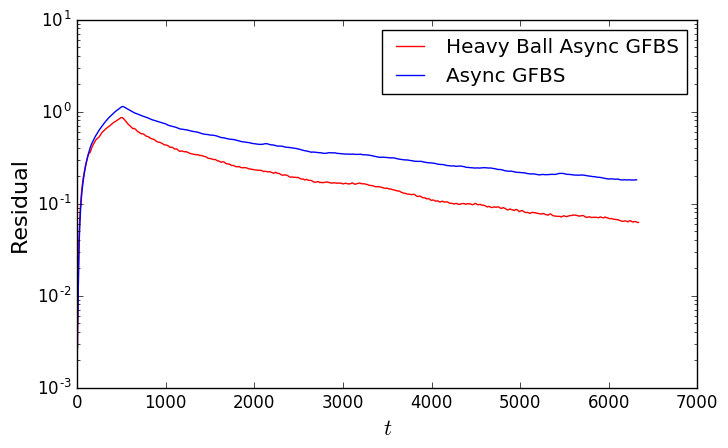

--------------------------------------------------------------------

 Results for Async HBGFBS

--------------------------------------------------------------------
X is:
 [0.0013167112637173517 0.022273016565619308 0.001203074467981402 0.0015375328175899483 0.06415064826146466 0.053598379787271 0.056573056370782915 0.09260175869447007 0.0012568647136808053 0.16000769825693872 0.09244525859844899 0.0015077204609275086 0.2499814222014134 0.10394428840877978 0.0015350272803456022 0.11842903093131518] 


 The optimal value is: 0.6522312784904851 


 Σ(x) is:
 1.0223614890807466 

error is:
 0.02699987807390518 


 total number of iters is:
 6337


Combined backtracking failed 1 0 5 84 sigma 0.999997
Combined backtracking failed 87 2 1 0 sigma 0.989175
Combined backtracking failed 12 0 0 78 sigma 0.999996
Combined backtracking failed 88 2 0 0 sigma 0.70058
Combined backtracking failed 0 0 0 90 sigma 0.999997
Combined backtracking failed 14 0 2 74 sigma 0.999997
Combined backtracking failed 26 0 0 64 sigma 0.999991
Combined backtracking failed 24 0 0 66 sigma 0.999984
Combined backtracking failed 32 0 0 58 sigma 0.999996
Combined backtracking failed 30 0 0 60 sigma 0.999986
Combined backtracking failed 0 0 0 90 sigma 0.999997
Combined backtracking failed 0 0 0 90 sigma 0.999997
Combined backtracking failed 45 0 0 45 sigma 0.999982
Combined backtracking failed 3 0 0 87 sigma 0.999997
Combined backtracking failed 29 0 3 58 sigma 0.999986
Combined backtracking failed 25 0 0 65 sigma 0.999995


PyObject <matplotlib.legend.Legend object at 0x32770ff60>

In [11]:
## Run a test

# reset update times
UpdateQueue = Dict{Int64,Float64}(zip(1:N+1, abs(rndUpdate)))

# initialize parameters
τ, ρ = ceil(collect(values(UpdateQueue))[indmax(collect(values(UpdateQueue)))] /
            collect(values(UpdateQueue))[indmin(collect(values(UpdateQueue)))]), 2
pmin = (1 / τ)
println("The delay is: $τ \n")

η = (1-1/ρ) * (N*sqrt(pmin)/8) * ( (ρ^(1/2)-1) / (ρ^((τ+1)/2)-1) )
η = 0.5
println("The stepsize is: $η \n")

ω_l = 0.5 / (N-1) # local weight
ω_g = 0.5 # global weight
Ω = [ω_l * ones(N-1); ω_g]

β = 0.7

# execute AsyncGFBS
optval = sum(OPT["optimal value central"])

x1, T1, NoUpdates1, res1, k1 = AsyncGFBS(3.0, UpdateQueue, Processor, optval, η, ω_l, ω_g, Ω);

println("--------------------------------------------------------------------")
println("\n Results for Async GFBS\n")
println("--------------------------------------------------------------------")
println("X is:\n $(x1[:,end]') \n")
println("\n The optimal value is: $(funEval(x1[:,end])) \n")
# println("T is:\n $T \n")
println("\n Σ(x) is:\n $(sum(x1[:,end])) \n")
error = norm(x1[:,end]-OPT["optimizer central"])
println("error is:\n $(error) \n")
println("\n total number of iters is:\n $k1")
println("\n\n")

sleep(3)

# reset update times
UpdateQueue = Dict{Int64,Float64}(zip(1:N+1, abs(rndUpdate)))

# execute AsyncHBGFBS
x2, T2, NoUpdates2, res2, k2 = AsyncHBGFBS(3.0, UpdateQueue, Processor, optval, η, β, ω_l, ω_g, Ω);

println("--------------------------------------------------------------------")
println("\n Results for Async HBGFBS\n")
println("--------------------------------------------------------------------")
println("X is:\n $(x2[:,end]') \n")
println("\n The optimal value is: $(funEval(x2[:,end])) \n")
# println("T is:\n $T \n")
println("\n Σ(x) is:\n $(sum(x2[:,end])) \n")
error = norm(x2[:,end]-OPT["optimizer central"])
println("error is:\n $(error) \n")
println("\n total number of iters is:\n $k2")

# plot
PyPlot.close("all")
fig = PyPlot.figure(1, figsize=(8, 4.6))
ax = subplot(111)
ax[:set_xlabel](L"$t$",fontsize=16)
ax[:set_ylabel]("Residual", fontsize=16)
ax[:semilogy](res2,"r",label="Heavy Ball Async GFBS")
ax[:semilogy](res1,"b",label="Async GFBS")
ax[:legend]()